In [6]:
# import packages
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import Bio
import statsmodels.api as sm


Import datasets and define variables

In [7]:
# import data from computer
path: str = './data/' #folder where files are stored
prokaryotes: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_unique_prot.csv"), dtype=str)   # imports file from the folder as species, based on name
prokaryotes_all: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_all.csv"), dtype=str) # imports 3rd file from the folder, based on name

Create a list of each unique protein for each organism

In [8]:
# prokaryotes
prokaryotes = prokaryotes_all.drop_duplicates(subset=['run_name', 'Protein_ID'], keep='first') #create new dataframe with only unique proteins
prokaryotes = prokaryotes.reset_index(drop=True) #reset index

# define meltpoint as float64
prokaryotes['meltPoint'] = prokaryotes['meltPoint'].astype('float64') # changes meltpoint column to float64
prokaryotes['temperature'] = prokaryotes['temperature'].astype('float64')

Calculate relative abundance of hydrophobic aminoacids for each protein and append to dataframe

In [9]:
from function import rel_aa_comp
from Aminoacid_lists import AA_hydrophobic, AA_polar_neutral, AA_acidic, AA_basic
prokaryotes['hydrophobic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_hydrophobic)) # calculates relative amino acid composition of hydrophobic amino acids
prokaryotes['polar_neutral'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_polar_neutral)) # calculates relative amino acid composition of polar neutral amino acids
prokaryotes['acidic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_acidic)) # calculates relative amino acid composition of acidic amino acids
prokaryotes['basic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_basic)) # calculates relative amino acid composition of basic amino acids



Group dataframes based on run name

In [10]:
prokaryotes_all_group = prokaryotes_all.groupby('run_name')
prokaryotes_group = prokaryotes.groupby('run_name')




Some plots to test data

In [13]:
sns.scatterplot(data = prokaryotes, x = 'auc', y = 'hydrophobic', label = 'hydrophobic', s= 10, alpha = 0.6)
sns.scatterplot(data=prokaryotes, x='auc', y='polar_neutral', label = 'polar neutral', s= 10, alpha = 0.6)
sns.scatterplot(data= prokaryotes, x='auc', y='acidic', label = 'acidic', s= 10, alpha = 0.6)
sns.scatterplot(data=prokaryotes, x='auc', y='basic', label = 'basic', s= 10, alpha = 0.6)
plt.xticks(np.arange(0, 2, 0.2))
plt.ylabel('relative abundance of aminoacid properties')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



KeyboardInterrupt: 

Calculate average hydrophic content for each organism and plot vs living temperature of organism

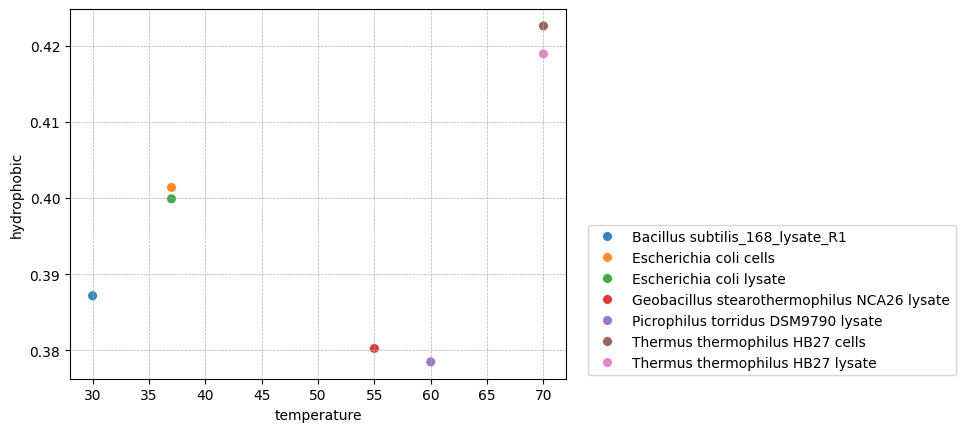

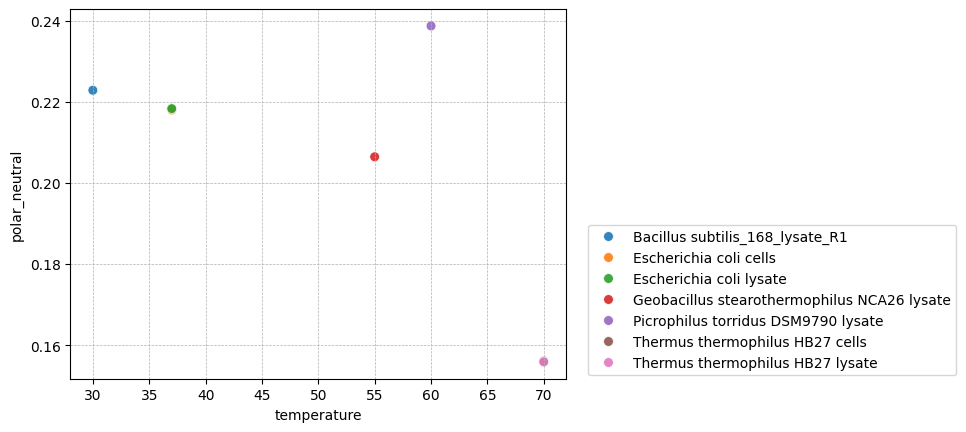

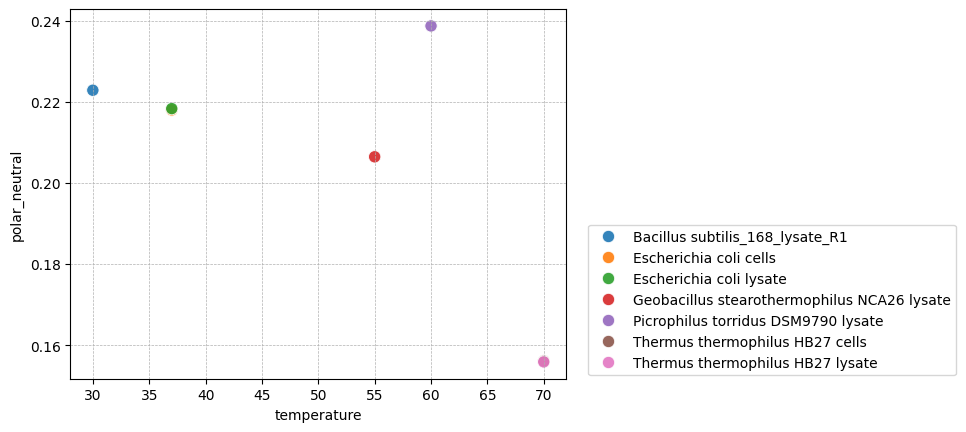

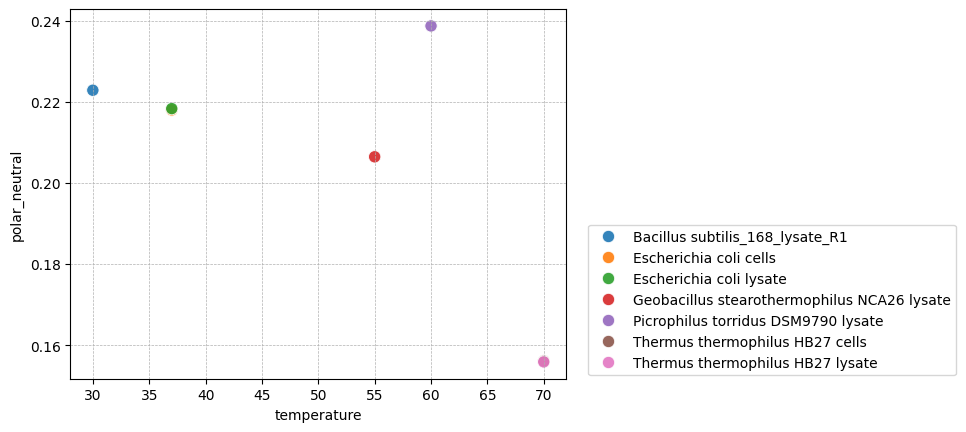

In [75]:
prokaryotes_average = prokaryotes_group.mean(['temperature', 'hydrophobic', 'acidic', 'polar_neutral', 'basic'])
prokaryotes_average = prokaryotes_average.reset_index()

#plot hydrophobic agaisnt temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y = 'hydrophobic', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot polar_neutral against temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot acidic against temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 80, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot basic against temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 80, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Test for lysine and aspartic acid as indicator for stable and unstable proteins, respectively

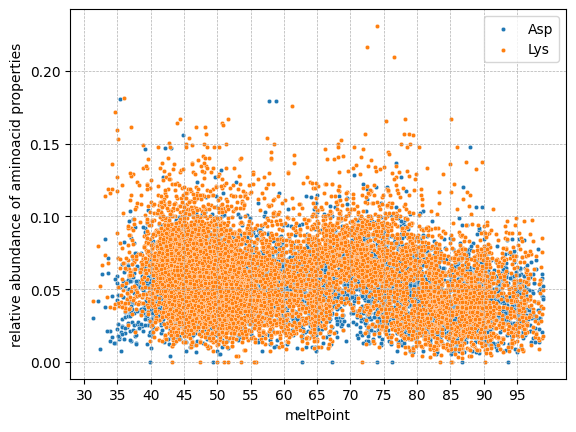

ValueError: Could not interpret value `Asp` for `y`. An entry with this name does not appear in `data`.

In [77]:
prokaryotes['Asp'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, ['D'])) # calculates relative Asp abundance
prokaryotes['Lys'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, ['K'])) # calculates relative Glu abundance

#plot individual proteins
sns.scatterplot(data=prokaryotes, x='meltPoint', y='Asp', label = 'Asp', s= 10, alpha = 1)
sns.scatterplot(data=prokaryotes, x='meltPoint', y='Lys', label = 'Lys', s= 10, alpha = 1)
plt.xticks(np.arange(30, 100, 5))
plt.ylabel('relative abundance of aminoacid properties')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#avg protein of each organism
prokaryotes_average = prokaryotes_group.mean(['temperature', 'hydrophobic', 'acidic', 'polar_neutral', 'basic', 'Asp', 'Lys'])
prokaryotes_average = prokaryotes_average.reset_index()


#plot avg Asp contant of each organism agaisnt OGT
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y = 'Asp', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#plot avg Lys contant of each organism agaisnt OGT
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y = 'Lys', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
